In [300]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [301]:
#Fake data
fd = {
    'distance': [random.randrange(0, 50) for i in range(100)],
    'angle': [random.randrange(0, 90) for i in range(100)],
    'isGoal': [random.randrange(0, 2) for i in range(100)],
    'emptyNet': [random.randrange(0, 2) for i in range(100)],
    
}

df = pd.DataFrame(fd)
df.head()

,distance,angle,isGoal,emptyNet
0,19,14,1,0
1,4,8,1,1
2,33,48,0,0
3,7,48,1,0
4,13,65,1,1


In [302]:
X = df[['distance', 'angle']]
y = df['isGoal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=73)

In [303]:
### Logistic regression on distance ###

X_train1 = X_train['distance'].to_numpy().reshape(-1, 1)
X_val1 = X_val['distance'].to_numpy().reshape(-1, 1)

lr_clf1 = LogisticRegression().fit(X_train1, y_train)

train_score1 = lr_clf1.score(X_train1, y_train)
val_score1 = lr_clf1.score(X_val1, y_val)

In [304]:
### Logistic regression on angle ###

X_train2 = X_train['angle'].to_numpy().reshape(-1, 1)
X_val2 = X_val['angle'].to_numpy().reshape(-1, 1)

lr_clf2 = LogisticRegression().fit(X_train2, y_train)

train_score2 = lr_clf2.score(X_train2, y_train)
val_score2 = lr_clf2.score(X_val2, y_val)

In [305]:
### Logistic regression on distance + angle ###

X_train3 = X_train.to_numpy().reshape(-1, 2)
X_val3 = X_val.to_numpy().reshape(-1, 2)

lr_clf3 = LogisticRegression().fit(X_train3, y_train)

train_score3 = lr_clf3.score(X_train3, y_train)
val_score3 = lr_clf3.score(X_val3, y_val)

In [306]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train3, y_train)

train_score4 = random_clf.score(X_train3, y_train)
val_score4 = random_clf.score(X_val3, y_val)

Logistic Regression (trained on distance only): ROC AUC=0.515
Logistic Regression (trained on angle only): ROC AUC=0.566
Logistic Regression (trained on both distance and angle): ROC AUC=0.545
Random: ROC AUC=0.500


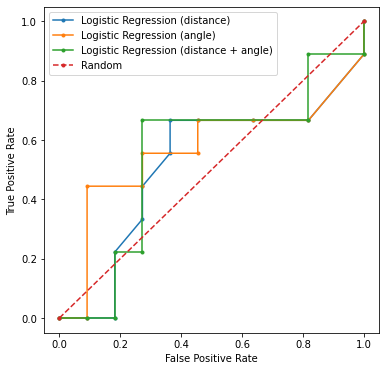

In [307]:
### ROC curve - AUC metric ###

lr_probs1 = lr_clf1.predict_proba(X_val1[:, :])[:,1]
lr_probs2 = lr_clf2.predict_proba(X_val2[:, :])[:,1]
lr_probs3 = lr_clf3.predict_proba(X_val3[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val3[:, :])[:,1]


lr_auc1 = roc_auc_score(y_val, lr_probs1)
lr_auc2 = roc_auc_score(y_val, lr_probs2)
lr_auc3 = roc_auc_score(y_val, lr_probs3)
random_auc = roc_auc_score(y_val, random_probs)

print('Logistic Regression (trained on distance only): ROC AUC=%.3f' % (lr_auc1))
print('Logistic Regression (trained on angle only): ROC AUC=%.3f' % (lr_auc2))
print('Logistic Regression (trained on both distance and angle): ROC AUC=%.3f' % (lr_auc3))
print('Random: ROC AUC=%.3f' % (random_auc))

lr_fpr1, lr_tpr1, _ = roc_curve(y_val, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(y_val, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(y_val, lr_probs3)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(lr_fpr1, lr_tpr1, marker='.', label='Logistic Regression (distance)')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Logistic Regression (angle)')
plt.plot(lr_fpr3, lr_tpr3, marker='.', label='Logistic Regression (distance + angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/roc.png')

plt.show()

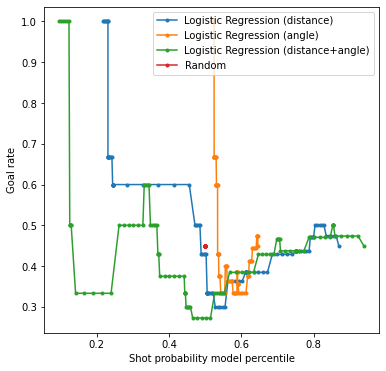

In [308]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates


percentiles1, rates1 = compute_goal_rate_per_percentile(lr_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(lr_probs2, y_val)
percentiles3, rates3 = compute_goal_rate_per_percentile(lr_probs3, y_val)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, marker='.', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

plt.savefig('../figures/goal_rate_percentile_1.png')

plt.show()

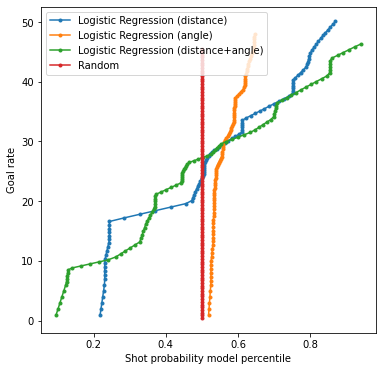

In [309]:
### cumulative portion of goals = F(shot probability model percentile) ###

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates


percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(lr_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(lr_probs2, y_val)
percentiles3, rates3 = compute_cumulative_goal_rate_per_percentile(lr_probs3, y_val)
percentiles4, rates4 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, marker='.', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

plt.savefig('../figures/goal_rate_percentile_2.png')

plt.show()

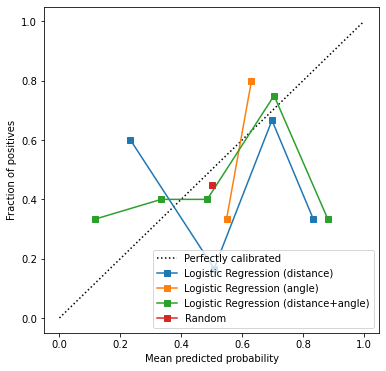

In [310]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(lr_clf1, X_val1, y_val, label='Logistic Regression (distance)', ax=ax)
disp2 = CalibrationDisplay.from_estimator(lr_clf2, X_val2, y_val, label='Logistic Regression (angle)', ax=ax)
disp3 = CalibrationDisplay.from_estimator(lr_clf3, X_val3, y_val, label='Logistic Regression (distance+angle)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val3, y_val, label='Random', ax=ax)

plt.savefig('../figures/calibration_diagram.png')

plt.show()